We're auditing the below starting profile -- it's special because candidate 1 gets exact quota in round 2. In fractional STV, this would make the election unauditable (because a single ballot can change the winner set), but with meek, this is not a problem.

![title](img/profile.png)

To audit this as a meek election, we just have to look at the branching paths that come from the different possible outcomes of round 2:

![title](img/branching_paths.png)

If the ballots were very noisy, it's possible we might not be able to conclude that 4 beats 5 in round 1 with high confidence. We would just add another branching path to deal with that, assuming that all branches eventually converge to the same winner set:

![title](img/noisy.png)

Below is a synthetic audit where 5% of the ballots are different than the CVRs (this is a high noise level -- Dr. Blom's group usually uses 1-2% noise). The audit has size $\alpha = .05$ -- we should only give false positives at most 5% of the time. We sample 10% of the N = 3100 ballots in the CVR, including some ballots that were exhausted for overvoting/undervoting/write-in reasons.

For the type of audit I'm doing, we would have to set n before sampling begins; this is not an arbitrary stopping time audit. This means that we should be strategic about picking n big enough so we feel comfortable we'll be able to audit the margins we have under random noise assumptions.

In [ ]:
import random
import numpy as np
from src.utils import noise_cvr_array
from margin_audits_old import deg0_sampler, deg1_sampler, cand_to_cand_deg1, cand_to_cand_deg0, cand_to_quota_deg0, cand_to_quota_deg1, project_sample
from src.plotting import plot_ballot_frequencies

noise_level = 0.05

CVR = [np.array([1,2,-1], dtype=np.int8)]*700 + [np.array([2,-1,-1], dtype=np.int8)] * 800 + [np.array([3,-1,-1], dtype=np.int8)] * 850 + [np.array([4,1,-1], dtype=np.int8)] * 350 + [np.array([5,1,-1], dtype=np.int8)] * 300 + [np.array([-1,-1,-1], dtype=np.int8)] * 100
CVR = np.array(CVR)
BAL = noise_cvr_array(CVR, candidates={1,2,3,4,5}, exhaust_sentinel=-1, noise_level=noise_level)

N = len(BAL)
n = N//10
# randomly sample n ballots from BAL and CVR, make them into a new array
sample_indices = random.sample(range(N), k=n)
BAL_sample = BAL[sample_indices]
CVR_sample = CVR[sample_indices]

## Step 1:
- Try to eliminate candidate 5.
- If the "5<4" test is not conclusive, add a branch 2b that eliminates 4 before 5.
- Check that none of 1, 2, or 3 have quota.

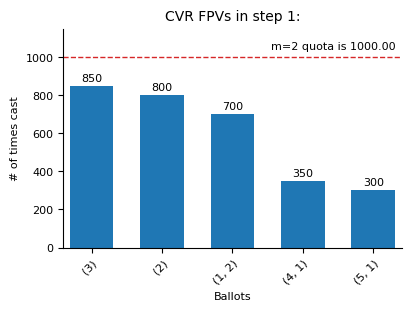

In [9]:
deg0_samples = deg0_sampler(BAL_sample, CVR_sample, hopeful={1,2,3,4,5}, exhaust_sentinel=-1)
deg1_samples = deg1_sampler(BAL_sample, CVR_sample, hopeful={2,3,4}, w=1, exhaust_sentinel=-1)

plot_ballot_frequencies(CVR, 2, title = "CVR FPVs in step 1:")

In [10]:
green_light = True
need_2b = False
M_54 = cand_to_cand_deg0(deg0_samples, 5, 4, Ti=300, Tj=350, N=N, n=n, alpha=0.05)
if M_54 < 0:
    print(f"Cand 5 conclusively loses to cand 4 with M={M_54}")
else:
    print(f"Can not discount reality 2b.")
    need_2b = True
M_53 = cand_to_cand_deg0(deg0_samples, 5, 3, Ti=300, Tj=850, N=N, n=n, alpha=0.05)
if M_53 < 0:
    print(f"Cand 5 conclusively loses to cand 3 with M={M_53}")
else:
    green_light = False
M_52 = cand_to_cand_deg0(deg0_samples, 5, 2, Ti=300, Tj=800, N=N, n=n, alpha=0.05)
if M_52 < 0:
    print(f"Cand 5 conclusively loses to cand 2 with M={M_52}")
else:
    green_light = False
M_51 = cand_to_cand_deg0(deg0_samples, 5, 1, Ti=300, Tj=700, N=N, n=n, alpha=0.05)
if M_51 < 0:
    print(f"Cand 5 conclusively loses to cand 1 with M={M_51}")
else:
    green_light = False
M_1q = cand_to_quota_deg0(deg0_samples, 1, sentinel=-1, Ti=700, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_1q[1] < 0:
    print(f"Cand 1 conclusively below quota by over M={M_1q[1]}")
else:
    green_light = False
M_2q = cand_to_quota_deg0(deg0_samples, 2, sentinel=-1, Ti=800, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_2q[1] < 0:
    print(f"Cand 2 conclusively below quota by over M={M_2q[1]}")
else:
    green_light = False
M_3q = cand_to_quota_deg0(deg0_samples, 3, sentinel=-1, Ti=850, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_3q[1] < 0:
    print(f"Cand 3 conclusively below quota by over M={M_3q[1]}")
else:
    green_light = False

print("-" * 150)
print("Conclusion for layer 1:")


if green_light and not need_2b:
    print("Green light to move to layer 2. No need for reality 2b.")
elif green_light and need_2b:
    print("Green light to move on to layer 2. Reality 2b needed.")
else:
    print("No green light to move to layer 2.")

Cand 5 conclusively loses to cand 4 with M=-31.75644485743953
Cand 5 conclusively loses to cand 3 with M=-495.85719624173225
Cand 5 conclusively loses to cand 2 with M=-435.8282513770422
Cand 5 conclusively loses to cand 1 with M=-375.82825137704214
Cand 1 conclusively below quota by over M=-258.8209781903753
Cand 2 conclusively below quota by over M=-193.736874617444
Cand 3 conclusively below quota by over M=-116.63893231289708
------------------------------------------------------------------------------------------------------------------------------------------------------
Conclusion for layer 1:
Green light to move to layer 2. No need for reality 2b.


## Step 2a:
Assuming 5 was previously eliminated:
- If a candidate is eliminated, it must be 4.
- If a candidate is elected, it must be 1.

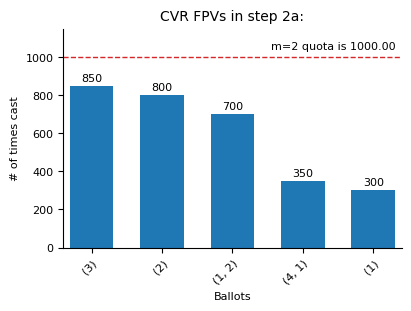

In [11]:
deg0_samples = deg0_sampler(BAL_sample, CVR_sample, hopeful={1,2,3,4}, exhaust_sentinel=-1)
projected_CVR = project_sample(CVR, hopeful={1,2,3,4}, elected = set())
#deg1_samples = deg1_sampler(BAL_sample, CVR_sample, hopeful={2,3,4}, w=1, exhaust_sentinel=-1)

plot_ballot_frequencies(projected_CVR, 2, title = "CVR FPVs in step 2a:")

In [12]:
green_light = True
need_3a = False
need_3b = False
M_43 = cand_to_cand_deg0(deg0_samples, 4, 3, Ti=350, Tj=850, N=N, n=n, alpha=0.05)
if M_43 < 0:
    print(f"Cand 4 conclusively loses to cand 3 with M={M_43}")
else:
    green_light = False
M_42 = cand_to_cand_deg0(deg0_samples, 4, 2, Ti=350, Tj=800, N=N, n=n, alpha=0.05)
if M_42 < 0:
    print(f"Cand 4 conclusively loses to cand 2 with M={M_42}")
else:
    green_light = False
M_41 = cand_to_cand_deg0(deg0_samples, 4, 1, Ti=350, Tj=1000, N=N, n=n, alpha=0.05)
if M_41 < 0:
    print(f"Cand 4 conclusively loses to cand 1 with M={M_41}")
else:
    green_light = False
M_1q = cand_to_quota_deg0(deg0_samples, 1, sentinel=-1, Ti=1000, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_1q[1] < 0:
    print(f"Cand 1 conclusively below quota by over M={M_1q[1]}")
    print("🚩🚩 THIS IS WEIRD 🚩🚩")
    green_light = False
elif M_1q[0] > 0:
    print(f"Cand 1 conclusively above quota by over M={M_1q[0]}")
    print("No need for reality 3b! This is convenient.")
    need_3a = True
elif M_1q[1] > 0:
    print(f"Cand 1 may or may not have quota, reality 3a and 3b both needed. CI for M_1q  is {M_1q}.")
    need_3a = True
    need_3b = True
M_2q = cand_to_quota_deg0(deg0_samples, 2, sentinel=-1, Ti=800, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_2q[1] < 0:
    print(f"Cand 2 conclusively below quota by over M={M_2q[1]}")
else:
    green_light = False
M_3q = cand_to_quota_deg0(deg0_samples, 3, sentinel=-1, Ti=850, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_3q[1] < 0:
    print(f"Cand 3 conclusively below quota by over M={M_3q[1]}")
else:
    green_light = False

print("-" * 150)
print("Conclusion for layer 2a:")


if green_light and not need_3b:
    print("Green light to move to layer 3a. No need for reality 3b.")
elif green_light and need_3b:
    print("Green light to move on to layer 3. Realities 3a and 3b both needed.")
else:
    print("No green light to move to layer 3.")

Cand 4 conclusively loses to cand 3 with M=-433.6533753479867
Cand 4 conclusively loses to cand 2 with M=-360.70232282861343
Cand 4 conclusively loses to cand 1 with M=-591.7564448574395
Cand 1 may or may not have quota, reality 3a and 3b both needed. CI for M_1q  is (np.float64(-63.84598003031319), np.float64(23.845978030313194)).
Cand 2 conclusively below quota by over M=-193.736874617444
Cand 3 conclusively below quota by over M=-109.96091527124602
------------------------------------------------------------------------------------------------------------------------------------------------------
Conclusion for layer 2a:
Green light to move on to layer 3. Realities 3a and 3b both needed.


## Step 2b:
Assuming 4 was previously eliminated:
- If a candidate is eliminated, it must be 5.
- If a candidate is elected, it must be 1.

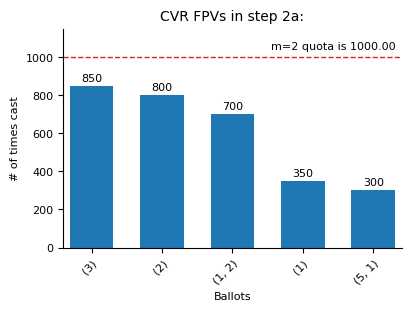

In [13]:
deg0_samples = deg0_sampler(BAL_sample, CVR_sample, hopeful={1,2,3,5}, exhaust_sentinel=-1)
projected_CVR = project_sample(CVR, hopeful={1,2,3,5}, elected = set())
#deg1_samples = deg1_sampler(BAL_sample, CVR_sample, hopeful={2,3,4}, w=1, exhaust_sentinel=-1)

plot_ballot_frequencies(projected_CVR, 2, title = "CVR FPVs in step 2a:")

In [14]:
if not need_2b:
    print("Skipping reality 2b.")
else:
    green_light = True
    #need_3b = False # if 3b is already needed, no need to set it again
    need_3c = False
    M_53 = cand_to_cand_deg0(deg0_samples, 5, 3, Ti=300, Tj=850, N=N, n=n, alpha=0.05)
    if M_53 < 0:
        print(f"Cand 5 conclusively loses to cand 3 with M={M_53}")
    else:
        green_light = False
    M_52 = cand_to_cand_deg0(deg0_samples, 5, 2, Ti=300, Tj=800, N=N, n=n, alpha=0.05)
    if M_52 < 0:
        print(f"Cand 5 conclusively loses to cand 2 with M={M_52}")
    else:
        green_light = False
    M_51 = cand_to_cand_deg0(deg0_samples, 5, 1, Ti=300, Tj=1050, N=N, n=n, alpha=0.05)
    if M_51 < 0:
        print(f"Cand 5 conclusively loses to cand 1 with M={M_51}")
    else:
        green_light = False
    M_1q = cand_to_quota_deg0(deg0_samples, 1, sentinel=-1, Ti=1050, Tg=100, N=N, m=2, n=n, alpha=0.05)
    if M_1q[1] < 0:
        print(f"Cand 1 conclusively below quota by over M={M_1q[1]}")
        print("🚩🚩 THIS IS WEIRD 🚩🚩")
        green_light = False
    elif M_1q[0] > 0:
        print(f"Cand 1 conclusively above quota by over M={M_1q[0]}")
        print("From 2b, it is not possible to get to 3b! But 3b may still be needed in another branch.")
        need_3c = True
    elif M_1q[1] > 0:
        print(f"Cand 1 may or may not have quota, reality 3a and 3b both needed. CI for M_1q  is {M_1q}.")
        need_3c = True
        need_3b = True
    M_2q = cand_to_quota_deg0(deg0_samples, 2, sentinel=-1, Ti=800, Tg=100, N=N, m=2, n=n, alpha=0.05)
    if M_2q[1] < 0:
        print(f"Cand 2 conclusively below quota by over M={M_2q[1]}")
    else:
        green_light = False
    M_3q = cand_to_quota_deg0(deg0_samples, 3, sentinel=-1, Ti=850, Tg=100, N=N, m=2, n=n, alpha=0.05)
    if M_3q[1] < 0:
        print(f"Cand 3 conclusively below quota by over M={M_3q[1]}")
    else:
        green_light = False

    print("-" * 150)
    print("Conclusion for layer 2a:")


    if green_light and not need_3b:
        print("Green light to move to layer 3c.")
    elif green_light and need_3b:
        print("Green light to move on to layer 3. Realities 3b and 3c both plausible from 2b.")
    else:
        print("No green light to move to layer 3.")

Skipping reality 2b.


## Reality 3a
Assuming 5 was eliminated and 1 was elected:
- 4 loses head-to-head against 2 and 3
- 2 and 3 do not have quota

N.b.: this is our first degree-1 audit (we have to worry about keep factors)

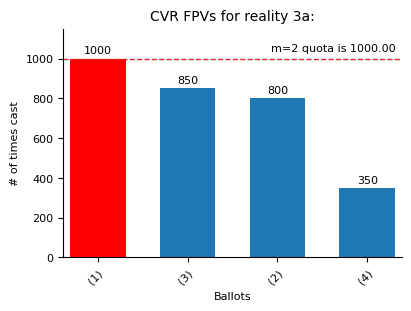

In [15]:
#custom_CVR = [np.array([1,2,-1], dtype=np.int8)]*700 # these are all kept by 1
custom_CVR = [np.array([2,-1,-1], dtype=np.int8)] * 800 
custom_CVR += [np.array([3,-1,-1], dtype=np.int8)] * 850 
custom_CVR += [np.array([4,-1,-1], dtype=np.int8)] * 350 
#custom_CVR += [np.array([5,1,-1], dtype=np.int8)] * 300 # 5 eliminated
custom_CVR += [np.array([-1,-1,-1], dtype=np.int8)] * 100
custom_CVR += [np.array([1,-1,-1], dtype=np.int8)]*1000
custom_CVR = np.array(custom_CVR)

deg0_samples = deg0_sampler(BAL_sample, CVR_sample, hopeful={1,2,3,4}, exhaust_sentinel=-1) # include 1 because we still need to know T_wg discrepancies
deg1_samples = deg1_sampler(BAL_sample, CVR_sample, hopeful={2,3,4}, w=1, exhaust_sentinel=-1)

plot_ballot_frequencies(custom_CVR, 2, title="CVR FPVs for reality 3a:", highlight_ballot = [1])

In [16]:
green_light = True
M_42 = cand_to_cand_deg1(
    deg0_samples,
    deg1_samples,
    w=1,
    i=4,
    j=2,
    Ti=350,
    Tj=800,
    Twi=0,
    Twj=700,
    Tg=100,
    Tw=1000,
    Twg=300,
    N=N,
    m=2,
    n=n,
    alpha=0.05,
    noise_level=0.05,
    sentinel=-1
)
if M_42 < 0:
    print(f"Cand 4 conclusively loses to cand 2 with M={M_42}")
else:
    green_light = False
M_43 = cand_to_cand_deg1(
    deg0_samples,
    deg1_samples,
    w=1,
    i=4,
    j=3,
    Ti=350,
    Tj=850,
    Twi=0,
    Twj=0,
    Tg=100,
    Tw=1000,
    Twg=300,
    N=N,
    m=2,
    n=n,
    alpha=0.05,
    noise_level=0.05,
    sentinel=-1
)
if M_43 < 0:
    print(f"Cand 4 conclusively loses to cand 3 with M={M_43}")
else:
    green_light = False

M_2q = cand_to_quota_deg1(deg0_samples, deg1_samples, w=1, i=2, Ti=800, Twi=700, Tg=100, Tw=1000, Twg=300, N= N, m=2, n=n,epsilon=1e-6, alpha = 0.05, noise_level=0.05,sentinel=-1)
if M_2q<0:
    print(f"Cand 2 conclusively below quota by M={M_2q}")
else:
    green_light = False
M_3q = cand_to_quota_deg1(deg0_samples, deg1_samples, w=1, i=3, Ti=850, Twi=0, Tg=100, Tw=1000, Twg=300, N= N, m=2, n=n,epsilon=1e-6, alpha = 0.05, noise_level=0.05,sentinel=-1)
if M_3q<0:
    print(f"Cand 3 conclusively below quota by M={M_3q}")
else:
    green_light = False

print("-" * 150)
print("Conclusion for layer 3a:")
if green_light:
    print("Green light to move to layer 4.")
else:
    print("No green light to move to layer 4.")

Cand 4 conclusively loses to cand 2 with M=-359.6769981997816
Cand 4 conclusively loses to cand 3 with M=-433.6691894230987
Cand 2 conclusively below quota by M=-193.52285588113574
Cand 3 conclusively below quota by M=-106.51472390290783
------------------------------------------------------------------------------------------------------------------------------------------------------
Conclusion for layer 3a:
Green light to move to layer 4.


## Reality 3b
Assuming 4 and 5 have both been eliminated:
- Candidate 1 definitely has quota
- Nobody else has quota

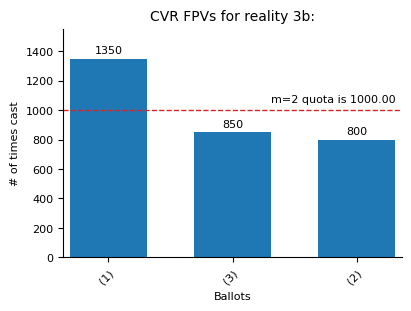

In [21]:
#custom_CVR = [np.array([1,2,-1], dtype=np.int8)]*700 # these are all kept by 1
custom_CVR = [np.array([2,-1,-1], dtype=np.int8)] * 800 
custom_CVR += [np.array([3,-1,-1], dtype=np.int8)] * 850 
#custom_CVR += [np.array([4,-1,-1], dtype=np.int8)] * 350  # 4 eliminated
#custom_CVR += [np.array([5,1,-1], dtype=np.int8)] * 300 # 5 eliminated
custom_CVR += [np.array([-1,-1,-1], dtype=np.int8)] * 100
custom_CVR += [np.array([1,-1,-1], dtype=np.int8)]*1350
custom_CVR = np.array(custom_CVR)

deg0_samples = deg0_sampler(BAL_sample, CVR_sample, hopeful={1,2,3}, exhaust_sentinel=-1) # include 1 because we still need to know T_wg discrepancies
deg1_samples = deg1_sampler(BAL_sample, CVR_sample, hopeful={2,3}, w=1, exhaust_sentinel=-1)

plot_ballot_frequencies(custom_CVR, 2, title="CVR FPVs for reality 3b:", highlight_ballot = [1,2])

In [18]:
green_light = True
M_1q = cand_to_quota_deg0(deg0_samples, 1, sentinel=-1, Ti=1350, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_1q[0] > 0:
    print(f"Cand 1 conclusively above quota by over M={M_1q[0]}")
else:
    green_light = False
M_2q = cand_to_quota_deg0(deg0_samples, 2, sentinel=-1, Ti=800, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_2q[1] < 0:
    print(f"Cand 2 conclusively below quota by over M={M_2q[1]}")
else:
    green_light = False
M_3q = cand_to_quota_deg0(deg0_samples, 3, sentinel=-1, Ti=850, Tg=100, N=N, m=2, n=n, alpha=0.05)
if M_3q[1] < 0:
    print(f"Cand 3 conclusively below quota by over M={M_3q[1]}")
else:
    green_light = False

print("-" * 150)
print("Conclusion for layer 3b:")
if green_light:
    print("Green light to move to layer 4.")
else:
    print("No green light to move to layer 4.")

Cand 1 conclusively above quota by over M=265.00289950594936
Cand 2 conclusively below quota by over M=-199.64656466467466
Cand 3 conclusively below quota by over M=-111.51718265224974
------------------------------------------------------------------------------------------------------------------------------------------------------
Conclusion for layer 3b:
Green light to move to layer 4.


## Layer 4:
Assuming 4, 5 are eliminated, and 1 is elected:
- 2 beats 3 in a head-to-head contest

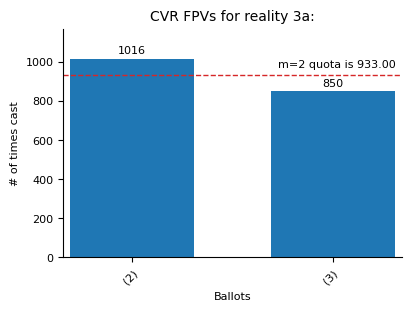

In [19]:
#custom_CVR = [np.array([1,2,-1], dtype=np.int8)]*700 # these are all kept by 1
custom_CVR = [np.array([2,-1,-1], dtype=np.int8)] * 1016
custom_CVR += [np.array([3,-1,-1], dtype=np.int8)] * 850 
#custom_CVR += [np.array([4,-1,-1], dtype=np.int8)] * 350  # 4 eliminated
#custom_CVR += [np.array([5,1,-1], dtype=np.int8)] * 300 # 5 eliminated
custom_CVR += [np.array([-1,-1,-1], dtype=np.int8)] * 100
#custom_CVR += [np.array([1,-1,-1], dtype=np.int8)]*1350
custom_CVR = np.array(custom_CVR)

deg0_samples = deg0_sampler(BAL_sample, CVR_sample, hopeful={1,2,3}, exhaust_sentinel=-1) # include 1 because we still need to know T_wg discrepancies
deg1_samples = deg1_sampler(BAL_sample, CVR_sample, hopeful={2,3}, w=1, exhaust_sentinel=-1)

plot_ballot_frequencies(custom_CVR, 2, title="CVR FPVs for reality 3a:", quota= 933, highlight_ballot = [1,2])

In [20]:
M_32 = cand_to_cand_deg1(
    deg0_samples,
    deg1_samples,
    w=1,
    i=3,
    j=2,
    Ti=850,
    Tj=800,
    Twi=0,
    Twj=700,
    Tg=100,
    Tw=1350,
    Twg=650,
    N=N,
    m=2,
    n=n,
    alpha=0.05,
    noise_level=0.05,
    sentinel=-1
)
if M_32 < 0:
    print(f"Cand 3 conclusively loses to cand 2 with M={M_32}")

print("-" * 150)
print("Audit successful!")

Cand 3 conclusively loses to cand 2 with M=-66.1462933364914
------------------------------------------------------------------------------------------------------------------------------------------------------
Audit successful!


For deg 1:

$M_{ij}= T_i - T_j + N\mu_0 + (1-k)(T_{wi} - T_{wj} + N\mu_1)$ where $k =\displaystyle\frac{c_u -\mu_u}{c_v+\mu_v}$.

$\vec{\theta}= (\mu_0,\mu_1, \mu_u,\mu_v)$.

In [6]:
#print any row of CVR_sample not equal to the corresponding row of BAL_sample
for i in range(len(CVR_sample)):
    if not np.array_equal(CVR_sample[i], BAL_sample[i]):
        print("Row", i, "differs:")
        print("BAL:", BAL_sample[i])
        print("CVR:", CVR_sample[i])

Row 30 differs:
BAL: [ 1 -1 -1]
CVR: [ 1  2 -1]
Row 41 differs:
BAL: [ 6 -1 -1]
CVR: [ 1  2 -1]
Row 48 differs:
BAL: [ 5 -1 -1]
CVR: [ 2 -1 -1]
Row 74 differs:
BAL: [ 1  4 -1]
CVR: [ 1  2 -1]
Row 80 differs:
BAL: [ 2  4 -1]
CVR: [ 2 -1 -1]
Row 89 differs:
BAL: [ 6 -1 -1]
CVR: [ 3 -1 -1]
Row 114 differs:
BAL: [ 1 -1 -1]
CVR: [ 1  2 -1]
Row 135 differs:
BAL: [ 6 -1 -1]
CVR: [ 5  1 -1]
Row 173 differs:
BAL: [ 5  3 -1]
CVR: [ 3 -1 -1]
Row 179 differs:
BAL: [ 6 -1 -1]
CVR: [ 5  1 -1]
Row 196 differs:
BAL: [ 6 -1 -1]
CVR: [ 2 -1 -1]
Row 210 differs:
BAL: [ 1  3 -1]
CVR: [ 3 -1 -1]
Row 212 differs:
BAL: [ 4  1 -1]
CVR: [-1 -1 -1]
Row 218 differs:
BAL: [ 3  1 -1]
CVR: [ 3 -1 -1]
Row 225 differs:
BAL: [2 4 1]
CVR: [ 4  1 -1]
Row 232 differs:
BAL: [ 5 -1 -1]
CVR: [ 2 -1 -1]
Row 285 differs:
BAL: [ 4  1 -1]
CVR: [ 5  1 -1]
Row 289 differs:
BAL: [ 6 -1 -1]
CVR: [ 2 -1 -1]
Row 291 differs:
BAL: [ 3 -1 -1]
CVR: [ 2 -1 -1]
Row 308 differs:
BAL: [ 3 -1 -1]
CVR: [ 2 -1 -1]


In [6]:
BAL_without_5 = project_sample(BAL, hopeful={1,2,3,4}, elected=set())
fpv = BAL_without_5[:,0]
fpv_1 = np.sum(fpv == 1)
fpv_1

np.int64(999)

In [7]:
deg0_samples[1].sum()

np.int64(-1)